In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import masking
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, view_img
import os, sys
from config import Config
from pathlib import Path
from nilearn.image import mean_img
from nilearn.image import resample_to_img

In [2]:
run = 1
ses = 1
sub = '04'

anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')
base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

Overlay Functional Image on Structural Image

In [3]:
anat_img = nib.as_closest_canonical(anat_img)
func_img = nib.as_closest_canonical(bold_img)
ornt_anat = nib.orientations.io_orientation(anat_img.affine)
ornt_func = nib.orientations.io_orientation(func_img.affine)
xform = nib.orientations.ornt_transform(ornt_func, ornt_anat)
view = view_img(mean_img(bold_img), bg_img=anat_img, title='BOLD Image on Anatomic Brain')  # shows sliders to move cuts
view.save_as_html(f"BOLD_data_on_Anat_sub{sub}_ses{ses}_run{run}.html")

/tmp/ipykernel_188082/1874063150.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  view = view_img(mean_img(bold_img), bg_img=anat_img, title='BOLD Image on Anatomic Brain')  # shows sliders to move cuts
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
def remove_background(mask, anat_file, bold_data):
    mask_in_run1_img = resample_to_img(
    source_img=mask,
    target_img=anat_file,
    interpolation='nearest'
)
    anat_data = anat_file.get_fdata()
    valid_run1 = np.isfinite(anat_data) & (anat_data != 0)
    mask_in_run1 = mask_in_run1_img.get_fdata().astype(bool)
    combined_mask = mask_in_run1 & valid_run1
    mask_4d = combined_mask[..., np.newaxis]

    bold_data_masked = bold_data * mask_4d
    active_voxels = np.any(bold_data_masked != 0, axis=-1)  
    final_mask = active_voxels & combined_mask
    masked_timeseries_3d = np.where(final_mask[..., None], bold_data, 0)

    active_voxels = np.any(masked_timeseries_3d != 0, axis=-1)
    coords = np.array(np.where(active_voxels)).T
    xmin, ymin, zmin = coords.min(axis=0)
    xmax, ymax, zmax = coords.max(axis=0)
    print(xmax, ymax, zmax)
    # crop to bounding box
    masked_timeseries_3d_cropped = masked_timeseries_3d[xmin:xmax+1, ymin:ymax+1, zmin:zmax+1, :]
    return masked_timeseries_3d_cropped, xmin, ymin, zmin

In [5]:
mask = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-1/anat/sub-pd004_ses-1_T1w_brain_mask.nii.gz')

bold_data_masked, xmin, ymin, zmin = remove_background(mask, anat_img, bold_data)
print(bold_data_masked.shape)

A = bold_img.affine.copy()
A[:3, 3] = A[:3, 3] + A[:3, :3] @ np.array([xmin, ymin, zmin], dtype=float)
bold_data_masked_img = nib.Nifti1Image(bold_data_masked, A, bold_img.header)
print(bold_data_masked_img.shape)

view = view_img(mean_img(bold_data_masked_img), bg_img=anat_img, title='BOLD Image on Anatomic Brain', cut_coords=(0,0,0))  # shows sliders to move cuts
view.save_as_html(f"Masked_BOLD_data_on_Anat_sub{sub}_ses{ses}_run{run}.html")

/tmp/ipykernel_188082/3880433289.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mask_in_run1_img = resample_to_img(
/tmp/ipykernel_188082/3880433289.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mask_in_run1_img = resample_to_img(


78 104 73
(69, 92, 73, 850)
(69, 92, 73, 850)


/tmp/ipykernel_188082/478411367.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  view = view_img(mean_img(bold_data_masked_img), bg_img=anat_img, title='BOLD Image on Anatomic Brain', cut_coords=(0,0,0))  # shows sliders to move cuts
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Remove Background Voexls, create design matrix, and run GLMsingle

Load GLMsingle Results

In [6]:
fmt = lambda x: f"{x:.3f}"
fmt_arr = lambda a: np.array2string(np.asarray(a), precision=3, separator=', ', suppress_small=True)

# ---------- Load GLM dict ----------
glm_dict = np.load('/home/zkavian/thesis_code_git/GLMOutputs-sub04-ses1/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()

print("Keys:", list(glm_dict.keys()))
print("betasmd shape:", glm_dict['betasmd'].shape, "\n")

# ---------- Noisepool percentage ----------
noisepool = glm_dict['noisepool'].astype(np.uint8)  
coord = np.where(noisepool)
num_voxels = noisepool.size
pct_noise = len(coord[0]) / num_voxels * 100
print(f"Detected Noise Voxels: {fmt(pct_noise)} %")

# ---------- Plot noisepool on anatomy ----------
# noisepool_img_func = new_img_like(bold_img, noisepool) 
# noisepool_on_anat = resample_to_img(noisepool_img_func, anat_img, interpolation='nearest')
noisepool_img = nib.Nifti1Image(noisepool, A, bold_img.header)
view = view_img(noisepool_img, bg_img=anat_img, threshold=0.5, title='Noisepool voxels')
view.save_as_html(file_name=f"Noisepool_Mask_on_the_brain_sub{sub}_ses{ses}_run{run}.html")

print() 

# ---------- FRAC value summaries (no MaskedArray warning) ----------
def unique_safely(x):
    if np.ma.isMaskedArray(x):
        return np.unique(x.compressed())
    return np.unique(x)

FRAC = glm_dict['FRACvalue']
all_vals = unique_safely(FRAC)
noisepool_vals = unique_safely(FRAC[coord])

print("Fractional Regularization Level:")
print("  All voxels unique:", fmt_arr(all_vals))
print("  Noisepool voxels unique:", fmt_arr(noisepool_vals))
print()

# ---------- Per-run summaries ----------
beta = glm_dict['betasmd']
beta_run1, beta_run2 = beta[..., :90], beta[..., 90:]
R2_run1, R2_run2 = glm_dict['R2run'][:,:,:,0], glm_dict['R2run'][:,:,:,1]

def stats_str(x):
    return f"max {fmt(np.nanmax(x))}, min {fmt(np.nanmin(x))}, mean {fmt(np.nanmean(x))}"

print("Beta Value:")
print("  Run1:", stats_str(beta_run1))
print("  Run2:", stats_str(beta_run2))
print()
print("R2 Value:")
print("  Run1:", stats_str(R2_run1))
print("  Run2:", stats_str(R2_run2))
print()

# ---------- % non-NaN (active) voxels ----------
n_total = beta_run1.size
pct_active_run1 = np.count_nonzero(~np.isnan(beta_run1)) / n_total * 100
pct_active_run2 = np.count_nonzero(~np.isnan(beta_run2)) / n_total * 100
print(f"Non-NaN (active) voxels: Run1 {fmt(pct_active_run1)} %, Run2 {fmt(pct_active_run2)} %")

# plot beta values on the brain

Keys: ['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol']
betasmd shape: (69, 92, 73, 180) 

Detected Noise Voxels: 29.452 %


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_186987/3495859221.py:21: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  view = view_img(noisepool_img, bg_img=anat_img, threshold=0.5, title='Noisepool voxels')



Fractional Regularization Level:
  All voxels unique: [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
 0.65, 0.7 , 0.75, 1.  ]
  Noisepool voxels unique: [0.05, 0.1 , 0.15, 0.2 ]

Beta Value:
  Run1: max 12023.069, min -2978.961, mean 0.009
  Run2: max 2439.105, min -4227.346, mean 0.026

R2 Value:
  Run1: max 37.737, min -6.138, mean 4.646
  Run2: max 61.058, min -21.858, mean 5.038

Non-NaN (active) voxels: Run1 45.410 %, Run2 45.410 %


In [7]:
beta_run1.shape

(69, 92, 73, 90)

In [8]:
beta_mean_run1 = np.nanmean(beta_run1, axis=-1)
beta_mean_run2 = np.nanmean(beta_run2, axis=-1)

# Consistent color scaling across 
both_beta_vals = np.concatenate([np.ravel(beta_mean_run1), np.ravel(beta_mean_run2)])
vmax_all = np.nanpercentile(np.abs(both_beta_vals), 99)  # robust maximum
vmin_all = -vmax_all

def save_beta_html(beta_3d, anat_img, A, title, fname):
    beta_on_anat = nib.Nifti1Image(beta_3d, A, bold_img.header)
    view = view_img(
        beta_on_anat,
        bg_img=anat_img,
        threshold=None,                # show everything; NaNs will be transparent
        symmetric_cmap=False,
        cmap='jet',
        vmin=vmin_all, vmax=vmax_all,
        title=title,
        colorbar=True,
        cut_coords=(0,0,0)
    )
    view.save_as_html(file_name=fname)
    print(f"Saved: {fname}")

# (1) Per-run beta maps (all voxels)
save_beta_html(beta_mean_run1, anat_img, A, f"All Beta", f"Beta_all_voxels_sub{sub}_ses{ses}_run1.html")
save_beta_html(beta_mean_run2, anat_img, A, f"All Beta", f"Beta_all_voxels_sub{sub}_ses{ses}_run2.html")

save_beta_html(np.abs(beta_mean_run1), anat_img, A, f"All Abs Beta", f"Beta_abs__all_voxels_sub{sub}_ses{ses}_run1.html")
save_beta_html(np.abs(beta_mean_run2), anat_img, A, f"All Abs Beta", f"Beta_abs_all_voxels_sub{sub}_ses{ses}_run2.html")

/tmp/ipykernel_186987/3666500369.py:1: RuntimeWarning: Mean of empty slice
  beta_mean_run1 = np.nanmean(beta_run1, axis=-1)
/tmp/ipykernel_186987/3666500369.py:2: RuntimeWarning: Mean of empty slice
  beta_mean_run2 = np.nanmean(beta_run2, axis=-1)
/tmp/ipykernel_186987/3666500369.py:11: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(
/tmp/ipykernel_186987/3666500369.py:11: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(
/tmp/ipykernel_186987/3666500369.py:11: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved: Beta_all_voxels_sub04_ses1_run1.html


/tmp/ipykernel_186987/3666500369.py:11: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(
/tmp/ipykernel_186987/3666500369.py:11: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  view = view_img(
/tmp/ipykernel_186987/3666500369.py:11: UserWarning: vmin cannot be chosen when cmap is symmetric
  view = view_img(
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved: Beta_all_voxels_sub04_ses1_run2.html


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved: Beta_abs__all_voxels_sub04_ses1_run1.html


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved: Beta_abs_all_voxels_sub04_ses1_run2.html


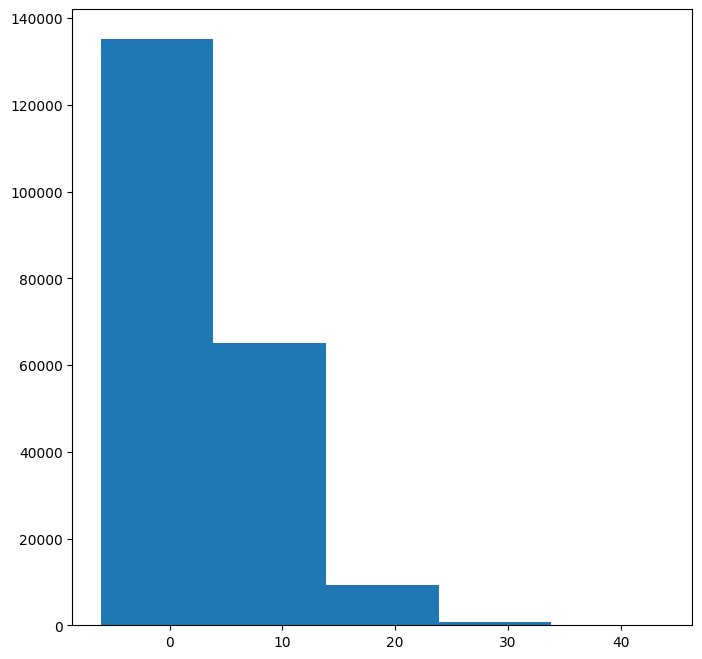

Histogram Bins: [-6.13777208  3.86222792 13.86222792 23.86222792 33.86222792 43.86222792], Number of bins: 5


In [9]:
bin_width = 10
X = R2_run1.ravel()
bins = np.arange(np.nanmin(X), np.nanmax(X) + bin_width, bin_width)

plt.figure(figsize=(8,8))
n, bins, patches = plt.hist(X, bins=bins)
plt.show()

print(f"Histogram Bins: {bins}, Number of bins: {int(len(patches))}")

In [19]:
n_bins = int(len(patches))

for i in range(n_bins):
    low, high = float(bins[i]), float(bins[i+1])
    if i < n_bins - 1:
        mask_i = (R2_run1 >= low) & (R2_run1 < high)
    else:
        mask_i = (R2_run1 >= low) & (R2_run1 <= high)
    
    mask_beta_3d = np.full(beta_mean_run1.shape, np.nan, dtype=float)
    mask_beta_3d[mask_i] = beta_mean_run1[mask_i]
    c_min, c_max = np.nanmin(mask_beta_3d), np.nanmax(mask_beta_3d)
    print(c_min, c_max)

    beta_on_anat = nib.Nifti1Image(mask_beta_3d, A, bold_img.header)
    view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
    view.save_as_html(file_name = f'Beta_mask_bin{i+1}_sub{sub}_ses{ses}_run1.html')

-7.857098579406738 13.206343650817871


/tmp/ipykernel_186987/1690697120.py:16: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-42.066619873046875 118.27816772460938


/tmp/ipykernel_186987/1690697120.py:16: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-18.964879989624023 58.21822738647461


/tmp/ipykernel_186987/1690697120.py:16: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-5.946022033691406 11.683488845825195


/tmp/ipykernel_186987/1690697120.py:16: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-3.1202824115753174 10.34862995147705


/tmp/ipykernel_186987/1690697120.py:16: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = view_img(beta_on_anat, bg_img=anat_img, title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]', colorbar=True,  cmap='seismic')
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
low_beta_3d = np.full(beta_mean_run1.shape, np.nan, dtype=float)
low_beta_3d[low_mask] = beta_mean_run1[low_mask]
high_beta_3d = np.full(beta_mean_run1.shape, np.nan, dtype=float)
high_beta_3d[high_mask] = beta_mean_run1[high_mask]

beta_on_anat = nib.Nifti1Image(low_beta_3d, A, bold_img.header)
view = view_img(beta_on_anat, bg_img=anat_img, title=f'Low R2 Beta (Run 1)', colorbar=True, cut_coords=(0,0,0))
view.save_as_html(file_name = f'Beta_low_mask_sub{sub}_ses{ses}_run1.html')

beta_on_anat = nib.Nifti1Image(high_beta_3d, A, bold_img.header)
view = view_img(beta_on_anat, bg_img=anat_img, title=f'High R2 Beta (Run 1)', colorbar=True, cut_coords=(0,0,0))
view.save_as_html(file_name = f'Beta_high_mask_sub{sub}_ses{ses}_run1.html')

In [39]:
r2_min = np.nanmin(R2_run1)
r2_max = np.nanmax(R2_run1)
r2_mean = np.nanmean(R2_run1)


low_mask = (R2_run1 >= r2_min) & (R2_run1 < r2_mean)
high_mask = (R2_run1 >= r2_mean) & (R2_run1 <= r2_max)

low_masked_beta = beta_mean_run1[low_mask]
high_masked_beta = beta_mean_run1[high_mask]
num_voxels = R2_run1[~np.isnan(R2_run1)].size

print(f"Low Mask Group: [{fmt(r2_min)}, {fmt(r2_mean)}]: {fmt(len(low_masked_beta)/num_voxels*100)}% of non-nan Voxels")
print(f"High Mask Group: [{fmt(r2_mean)}, {fmt(r2_max)}]: {fmt(len(high_masked_beta)/num_voxels*100)}% of non-nan Voxels")

Low Mask Group: [-6.138, 4.646]: 67.790% of non-nan Voxels
High Mask Group: [4.646, 37.737]: 32.210% of non-nan Voxels
